In [1]:
from PIL import Image
import glob
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


In [2]:
labels = pd.read_csv("../Xray_TeethLabels_Simple.csv",index_col=0)
Ylabels = labels[5:]
metaY = labels[:3]
X = []
Y = []
for picFilename in glob.glob("../processed2/processed/*"):
    #print(picFilename)
    #print(picFilename.split('/')[3])
    #print(picFilename.split('/')[3].split('_')[1])
    patNumber = picFilename.split('/')[3].split('_')[0]
    toothNumber = picFilename.split('/')[3].split('_')[1].split('.')[0]
    im = Image.open(picFilename)
    X.append(np.array(im))
    if (Ylabels.loc[toothNumber,patNumber] == "Yes"):
        Y.append(1)
    else:
        Y.append(0)
X = np.array(X)
X_train, X_test, Y_train_original, Y_test_original = train_test_split(X, np.array(Y), random_state = 100, test_size=0.20)
Y_train = Y_train_original.astype(int)
Y_test = Y_test_original.astype(int)


In [30]:
print(X_train.shape)

(179, 500, 500, 3)


############################# **Keras SVM model** ######################################

In [5]:
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense,Activation
import tensorflow as tf



model_keras = Sequential()
model_keras.add(Dense(64, activation='relu'))
model_keras.add(Dense(1, kernel_regularizer=l2(0.01)))
model_keras.add(Activation('linear'))
model_keras.compile(loss='hinge',
              optimizer='adadelta',
              metrics=['accuracy'])

model_keras.fit(X_train, Y_train)

6/6 [==============================] - 22s 3s/step - loss: 7.4633 - accuracy: 0.4349


In [21]:
print(model_keras.predict)

<bound method Model.predict of <keras.engine.sequential.Sequential object at 0x7feb288a8be0>>


############################# **Image Explainer using Keras** ######################################

In [8]:
%%time
from lime import lime_image

print(X_train[10].shape)
explainer = lime_image.LimeImageExplainer()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(X_train[10], model_keras.predict, hide_color=0)

(500, 500, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

ValueError: Found array with dim 5. Estimator expected <= 2.

############################# **Image Explainer using SHAP** ######################################

In [48]:
import shap
import tensorflow as tf
import cv2

In [49]:
print(X_train[10].shape)

(500, 500, 3)


In [50]:
# define a masker that is used to mask out partitions of the input image, this one uses a blurred background
masker = shap.maskers.Image("inpaint_telea", X_train[10].shape)

In [51]:
def f2(X_train):
    tmp = X_train.copy()
    preprocess_input(tmp)
    return model_keras(tmp)

In [52]:
classes=[0,1]
explainer = shap.Explainer(f2, masker, output_names=classes)

In [53]:
shap_values = explainer(X_train[10], max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])
shap.image_plot(shap_values)

Exception: The length of the image to be masked must match the shape given in the ImageMasker contructor: 500 * 3 != 500 * 500 * 3

############################# **Demo SHAP** ######################################

In [13]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import json
import shap
import tensorflow as tf

# load pre-trained model and choose two images to explain
model = ResNet50(weights='imagenet')
def f(X):
    tmp = X.copy()
    preprocess_input(tmp)
    return model(tmp)
X, y = shap.datasets.imagenet50()

102981632/102967424 [==============================] - 4s 0us/step


In [47]:
print(f(X))

tf.Tensor(
[[4.73113140e-08 2.46383507e-07 6.93399542e-08 ... 2.51362593e-07
  7.33930938e-06 1.46825727e-07]
 [8.62808225e-09 2.41039011e-08 1.18881571e-08 ... 6.46189505e-07
  6.42557666e-07 3.77916217e-06]
 [2.04678696e-09 1.56931989e-07 4.85808982e-07 ... 7.89002697e-10
  6.07811046e-09 1.10308729e-09]
 ...
 [8.87646479e-07 7.42061417e-08 1.09816665e-06 ... 3.99042989e-07
  4.18003680e-07 6.60124579e-06]
 [1.94954737e-05 1.53953707e-07 3.78067497e-08 ... 3.76866615e-06
  1.02418111e-04 4.71072053e-06]
 [3.56733323e-11 3.22578110e-11 1.42153835e-08 ... 4.34719455e-10
  1.20487031e-09 8.63605631e-09]], shape=(50, 1000), dtype=float32)


['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead', 'electric_ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house_finch', 'junco', 'indigo_bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water_ouzel', 'kite', 'bald_eagle', 'vulture', 'great_grey_owl', 'European_fire_salamander', 'common_newt', 'eft', 'spotted_salamander', 'axolotl', 'bullfrog', 'tree_frog', 'tailed_frog', 'loggerhead', 'leatherback_turtle', 'mud_turtle', 'terrapin', 'box_turtle', 'banded_gecko', 'common_iguana', 'American_chameleon', 'whiptail', 'agama', 'frilled_lizard', 'alligator_lizard', 'Gila_monster', 'green_lizard', 'African_chameleon', 'Komodo_dragon', 'African_crocodile', 'American_alligator', 'triceratops', 'thunder_snake', 'ringneck_snake', 'hognose_snake', 'green_snake', 'king_snake', 'garter_snake', 'water_snake', 'vine_snake', 'night_snake', 'boa_constrictor', 'rock_python', 'Indian_cobra', 'green_mamba', 'sea_snake', 'horned_viper', 'diamondback', 

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 3it [00:39, 19.88s/it]               


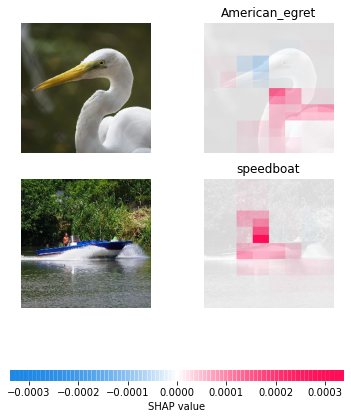

In [35]:
# load the ImageNet class names as a vectorized mapping function from ids to names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]

# define a masker that is used to mask out partitions of the input image, this one uses a blurred background
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# By default the Partition explainer is used for all  partition explainer
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we use 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(X[1:3], max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])
shap.image_plot(shap_values)